<a href="https://colab.research.google.com/github/Ritapaz/projeto/blob/main/Gest%C3%A3o_de_estoques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simulação, ao longo de T dias, um item estocado em um CD/depósito com:

* Demanda diária estocástica (ex.: Poisson ou Normal truncada)

* Reposição com lead time (tempo de entrega do fornecedor)

* Política (s, S):

    * s = estoque mínimo / ponto de pedido (reorder point)

    * S = estoque-alvo (order-up-to level)

      Quando a posição de estoque ≤ s, faz-se um pedido para elevar a posição até S.

**Conceitos-chave monitorados**

* Estoque disponível (on-hand): o que está fisicamente no depósito.

* Em trânsito (on-order/pipeline): pedidos já feitos e ainda não entregues.

* Posição de estoque: on_hand + on_order - backorder (se houver backorder).

**Objetivos**

**Objetivo geral**

Avaliar o desempenho de uma política de reposição (s, S) sob incerteza de demanda e lead time.

**Objetivos específicos**

* Medir nível médio de estoque (on-hand médio) e estoque mínimo observado.

* Quantificar rupturas:

     * frequência de dias com ruptura

     * unidades em falta (lost sales ou backorder)

* Estimar custos:

     * custo de manutenção (holding)

     * custo de pedido (fixo + variável, se desejar)

     * custo de ruptura (penalidade por unidade não atendida)

* Comparar cenários variando:

     * s,S

     * distribuição da demanda

     * lead time

**Pseudocódigo**

Assumindo lost sales (venda perdida) para simplificar: se não tiver estoque, a demanda não atendida vira ruptura.

**entrada**: T, s, S, distribuição_demanda, lead_time (fixo ou aleatório),
         custos: holding_cost, order_cost_fixed, order_cost_per_unit, stockout_cost

**estado**:
    on_hand = estoque_inicial
    pedidos_em_aberto = lista de (dia_entrega, quantidade)

**métricas**:
    estoque_on_hand[dia]
    posicao_estoque[dia]
    pedidos[dia]
    ruptura_unidades[dia]
    ruptura_flag[dia]
    custo_holding[dia], custo_pedido[dia], custo_ruptura[dia]

para dia = 1 até T:

    1) Recebimentos:
        somar ao on_hand todas as quantidades com dia_entrega == dia
        remover esses pedidos da lista

    2) Demanda:
        demand = gerar_demanda()
        atendido = min(on_hand, demand)
        falta = demand - atendido
        on_hand -= atendido

        ruptura_unidades[dia] = falta
        ruptura_flag[dia] = (falta > 0)

    3) Decisão de pedido:
        on_order = soma das quantidades em pedidos_em_aberto
        posicao = on_hand + on_order   (lost sales, sem backorder)
        se posicao <= s:
            q = S - posicao
            agendar entrega em (dia + lead_time) com quantidade q
            registrar pedido q

    4) Custos do dia:
        holding = holding_cost * on_hand
        pedido = (order_cost_fixed + order_cost_per_unit*q) se houve pedido
        ruptura = stockout_cost * falta

no fim:

    calcular KPIs:
      estoque médio, mínimo, taxa de ruptura (dias), fill rate,
      custo total e por componente
    gerar gráficos (série do estoque, rupturas, custos)

===== KPIs DO ESTOQUE (política s, S) =====
Estoque médio (on-hand): 5.93
Estoque mínimo observado: 0
Dias com ruptura: 89 (49.44%)
Fill rate (vendas/demanda): 78.75%
Nº de pedidos: 163 | Qtd média por pedido: 17.41

----- Custos no horizonte -----
Custo holding:  213.40
Custo pedidos:  8150.00
Custo rupturas: 3815.00
Custo total:    12178.40


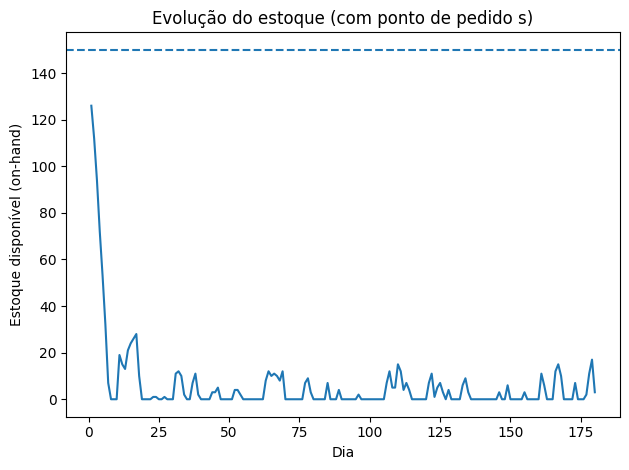

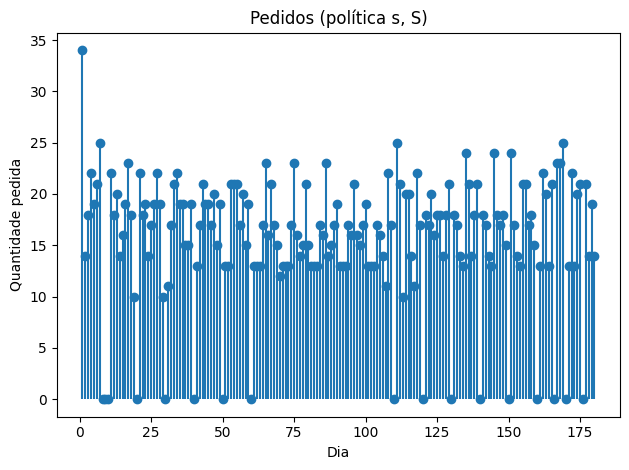

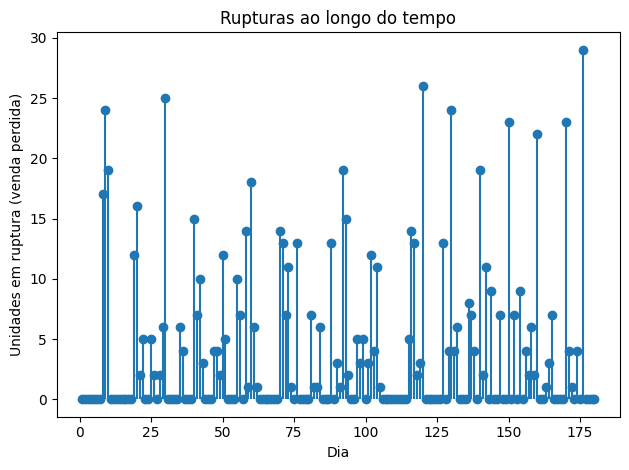

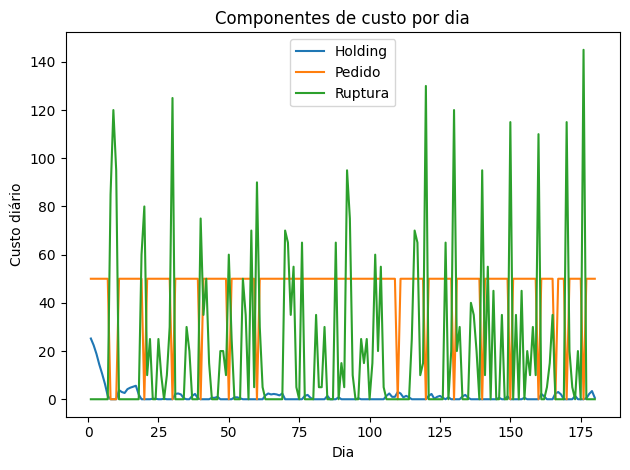

In [13]:
from __future__ import annotations

from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict

import numpy as np
import matplotlib.pyplot as plt


@dataclass
class InventoryParams:
    # Horizonte
    horizon_days: int = 180

    # Política (s, S)
    reorder_point_s: int = 80
    order_up_to_S: int = 200

    # Estoque inicial
    initial_on_hand: int = 150

    # Demanda (ex.: Poisson)
    demand_dist: str = "poisson"  # "poisson" ou "normal_trunc"
    demand_lambda: float = 20.0
    demand_normal_mean: float = 20.0
    demand_normal_std: float = 6.0

    # Lead time (dias)
    lead_time_dist: str = "fixed"  # "fixed" ou "uniform_int"
    lead_time_fixed: int = 5
    lead_time_min: int = 3
    lead_time_max: int = 7

    # Custos
    holding_cost_per_unit_per_day: float = 0.20
    order_cost_fixed: float = 50.0
    order_cost_per_unit: float = 0.0
    stockout_cost_per_unit: float = 5.0

    seed: int = 42


@dataclass
class InventoryResults:
    on_hand: np.ndarray
    inventory_position: np.ndarray
    demand: np.ndarray
    sales: np.ndarray
    lost_sales: np.ndarray
    orders_qty: np.ndarray

    cost_holding: np.ndarray
    cost_order: np.ndarray
    cost_stockout: np.ndarray


def generate_demand(rng: np.random.Generator, p: InventoryParams) -> int:
    if p.demand_dist == "poisson":
        return int(rng.poisson(lam=p.demand_lambda))
    if p.demand_dist == "normal_trunc":
        x = rng.normal(loc=p.demand_normal_mean, scale=p.demand_normal_std)
        return int(max(0, round(x)))
    raise ValueError("demand_dist inválida. Use 'poisson' ou 'normal_trunc'.")


def generate_lead_time(rng: np.random.Generator, p: InventoryParams) -> int:
    if p.lead_time_dist == "fixed":
        return int(p.lead_time_fixed)
    if p.lead_time_dist == "uniform_int":
        return int(rng.integers(p.lead_time_min, p.lead_time_max + 1))
    raise ValueError("lead_time_dist inválida. Use 'fixed' ou 'uniform_int'.")


def simulate_inventory(p: InventoryParams) -> InventoryResults:
    rng = np.random.default_rng(p.seed)

    T = p.horizon_days
    on_hand = np.zeros(T, dtype=int)
    inv_pos = np.zeros(T, dtype=int)
    demand = np.zeros(T, dtype=int)
    sales = np.zeros(T, dtype=int)
    lost = np.zeros(T, dtype=int)
    orders_qty = np.zeros(T, dtype=int)

    cost_h = np.zeros(T, dtype=float)
    cost_o = np.zeros(T, dtype=float)
    cost_s = np.zeros(T, dtype=float)

    # Estado
    current_on_hand = int(p.initial_on_hand)

    # Pedidos em aberto: lista de (day_to_arrive, qty)
    pipeline: List[Tuple[int, int]] = []

    for day in range(T):
        day_index = day  # 0..T-1

        # 1) Recebimentos
        arrivals_today = 0
        remaining_pipeline: List[Tuple[int, int]] = []
        for arrive_day, qty in pipeline:
            if arrive_day == day_index:
                arrivals_today += qty
            else:
                remaining_pipeline.append((arrive_day, qty))
        pipeline = remaining_pipeline
        current_on_hand += arrivals_today

        # 2) Demanda e vendas (lost sales)
        d = generate_demand(rng, p)
        demand[day_index] = d

        sold = min(current_on_hand, d)
        shortage = d - sold

        current_on_hand -= sold
        sales[day_index] = sold
        lost[day_index] = shortage

        # 3) Política de reposição (s, S) usando posição de estoque
        on_order = sum(qty for _, qty in pipeline)
        position = current_on_hand + on_order  # lost sales, sem backorder

        q = 0
        if position <= p.reorder_point_s:
            q = p.order_up_to_S - position
            if q > 0:
                lt = generate_lead_time(rng, p)
                arrive_day = day_index + lt
                # Se chegar após o horizonte, ainda conta custo do pedido, mas não entra no estoque simulado
                pipeline.append((arrive_day, q))
        orders_qty[day_index] = q

        # Atualiza posição após decisão (inclui o pedido recém-feito)
        on_order_after = sum(qty for _, qty in pipeline)
        position_after = current_on_hand + on_order_after

        # 4) Registrar estado do dia
        on_hand[day_index] = current_on_hand
        inv_pos[day_index] = position_after

        # 5) Custos
        cost_h[day_index] = p.holding_cost_per_unit_per_day * current_on_hand
        cost_o[day_index] = (p.order_cost_fixed + p.order_cost_per_unit * q) if q > 0 else 0.0
        cost_s[day_index] = p.stockout_cost_per_unit * shortage

    return InventoryResults(
        on_hand=on_hand,
        inventory_position=inv_pos,
        demand=demand,
        sales=sales,
        lost_sales=lost,
        orders_qty=orders_qty,
        cost_holding=cost_h,
        cost_order=cost_o,
        cost_stockout=cost_s,
    )


def kpis(p: InventoryParams, r: InventoryResults) -> Dict[str, float]:
    avg_on_hand = float(np.mean(r.on_hand))
    min_on_hand = float(np.min(r.on_hand))

    days_stockout = int(np.sum(r.lost_sales > 0))
    stockout_rate_days = float(days_stockout / p.horizon_days)

    total_demand = float(np.sum(r.demand))
    total_sales = float(np.sum(r.sales))
    fill_rate = float(total_sales / total_demand) if total_demand > 0 else 1.0

    total_h = float(np.sum(r.cost_holding))
    total_o = float(np.sum(r.cost_order))
    total_s = float(np.sum(r.cost_stockout))
    total_cost = total_h + total_o + total_s

    num_orders = int(np.sum(r.orders_qty > 0))
    avg_order_qty = float(np.mean(r.orders_qty[r.orders_qty > 0])) if num_orders > 0 else 0.0

    return {
        "avg_on_hand": avg_on_hand,
        "min_on_hand": min_on_hand,
        "stockout_days": float(days_stockout),
        "stockout_rate_days": stockout_rate_days,
        "fill_rate": fill_rate,
        "num_orders": float(num_orders),
        "avg_order_qty": avg_order_qty,
        "total_cost": total_cost,
        "cost_holding": total_h,
        "cost_order": total_o,
        "cost_stockout": total_s,
    }


def plot_results(p: InventoryParams, r: InventoryResults) -> None:
    days = np.arange(1, p.horizon_days + 1)

    # Série do estoque on-hand
    plt.figure()
    plt.plot(days, r.on_hand)
    plt.axhline(p.reorder_point_s, linestyle="--")
    plt.xlabel("Dia")
    plt.ylabel("Estoque disponível (on-hand)")
    plt.title("Evolução do estoque (com ponto de pedido s)")
    plt.tight_layout()

    # Pedidos ao longo do tempo
    plt.figure()
    plt.stem(days, r.orders_qty, basefmt=" ")
    plt.xlabel("Dia")
    plt.ylabel("Quantidade pedida")
    plt.title("Pedidos (política s, S)")
    plt.tight_layout()

    # Rupturas (lost sales)
    plt.figure()
    plt.stem(days, r.lost_sales, basefmt=" ")
    plt.xlabel("Dia")
    plt.ylabel("Unidades em ruptura (venda perdida)")
    plt.title("Rupturas ao longo do tempo")
    plt.tight_layout()

    # Custos por dia
    plt.figure()
    plt.plot(days, r.cost_holding, label="Holding")
    plt.plot(days, r.cost_order, label="Pedido")
    plt.plot(days, r.cost_stockout, label="Ruptura")
    plt.xlabel("Dia")
    plt.ylabel("Custo diário")
    plt.title("Componentes de custo por dia")
    plt.legend()
    plt.tight_layout()

    plt.show()


def main() -> None:
    params = InventoryParams(
        horizon_days=180,
        reorder_point_s=150,
        order_up_to_S=160,
        initial_on_hand=150,
        demand_dist="poisson",
        demand_lambda=20.0,
        lead_time_dist="fixed",
        lead_time_fixed=10,
        holding_cost_per_unit_per_day=0.20,
        order_cost_fixed=50.0,
        order_cost_per_unit=0.0,
        stockout_cost_per_unit=5.0,
        seed=42,
    )

    results = simulate_inventory(params)
    summary = kpis(params, results)

    print("===== KPIs DO ESTOQUE (política s, S) =====")
    print(f"Estoque médio (on-hand): {summary['avg_on_hand']:.2f}")
    print(f"Estoque mínimo observado: {summary['min_on_hand']:.0f}")
    print(f"Dias com ruptura: {summary['stockout_days']:.0f} ({summary['stockout_rate_days']:.2%})")
    print(f"Fill rate (vendas/demanda): {summary['fill_rate']:.2%}")
    print(f"Nº de pedidos: {summary['num_orders']:.0f} | Qtd média por pedido: {summary['avg_order_qty']:.2f}")
    print("")
    print("----- Custos no horizonte -----")
    print(f"Custo holding:  {summary['cost_holding']:.2f}")
    print(f"Custo pedidos:  {summary['cost_order']:.2f}")
    print(f"Custo rupturas: {summary['cost_stockout']:.2f}")
    print(f"Custo total:    {summary['total_cost']:.2f}")

    plot_results(params, results)


if __name__ == "__main__":
    main()